# Baseline Models

- Using three baseline models for text classification, training a model to identify political language in court documents. The three classification algorithms used are:
    1. Logistic regression
    2. Naive Bayes
    3. Support Vector Classification

## Next steps

- Data needs more sentences labelled as political, as data is imbalanced and models observe few political sentences
- Need to optimize hyperparameters to improve model performance

In [34]:
import glob
import os
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import PrecisionRecallCurve, roc_auc


In [35]:
# load all json files in data directory
files = glob.glob("data/json/*.json")
data = []

# for loop for processing files and adding doc id
for json in files:
    frame = pd.read_json(json)
    # get file name as string
    # create column identifying dfs as doc_id
    # split string (remove .json from file name)
    frame["doc_id"] = os.path.splitext(os.path.basename(json))[0]
    data.append(frame)

# concatenate all data frames
df = pd.concat(data, ignore_index=True)

## Cleaning Text

In [36]:
# turn label_id into binary variable
# numpy where function states:
# where label_id is not 4, change to 0, otherwise change to 1

df["label_id"] = np.where(df["label_id"] != 4, 0, 1)


In [37]:
def preprocessing(text):

    text = re.sub("<[^>]*>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.lower().split() if not word in stop_words]
    text = " ".join(words)

    return text

In [38]:
df["text"] = df["text"].apply(preprocessing)


In [39]:
ps = PorterStemmer()


def token_ps(text):
    return [ps.stem(word) for word in text.split()]

## Logistic Regression

Logistic regression is a binary classifier that uses the weighted combination of the input features and models them using a sigmoid function, which gives outputs between 0 and 1. Logistic regression models the probability that _y_, the dependent variable, belongs to a particular class.

- The logistic regression model is based on the values created from a vectorizer algorithm called tf-idf, which stands for term-frequency inverse document frequency.
- tf-idf measures the originality of the word by comparing how often it appears in a doc with the number of docs the word appears in. The frequency of the words in a doc (compared against other docs) measures the importance of that word in the wider corpus.
- The logistic regression below is computed by building a vector of word values based on the importance of each word, before using the word vectors to identify the characteristics of the political label to predict which sentences will be political.

In [40]:
# transforming text into vectors
tfidf = TfidfVectorizer(lowercase=False, use_idf=True, norm="l2", smooth_idf=True)
# compute tfidf values for all words in 'text' column of df
X = tfidf.fit_transform(df["text"])
y = df.label_id.values

In [41]:
# splitting data into train and test splits in order to test predictive accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, shuffle=True
)

In [42]:
# computes and then fits logistic regression that implements cross-validation as a part of the process
# cv = number of cross validation folds
log_reg = LogisticRegressionCV(cv=8, scoring="accuracy", n_jobs=-1)

# fit model
log_reg.fit(X_train, y_train)

# model accuracy
log_predictions = log_reg.predict(X_test)


In [43]:
# defining a function that prints model prediction accuracy
def model_accuracy(name, preds):
    print("---{} Test Set Results---".format(name))
    print("Weighted F1 Average: {}".format(f1_score(y_test, preds, average="weighted")))
    # precision = % predicted accurately
    # recall = % positives identified
    # f1-score = weighted harmonic mean of precision & recall
    # weighted f-1 avg used for comparing classification models
    print(classification_report(y_test, preds))

In [44]:
model_accuracy("Logit", log_predictions)

---Logit Test Set Results---
Weighted F1 Average: 0.8000997426850943
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       127
           1       1.00      0.05      0.09        22

    accuracy                           0.86       149
   macro avg       0.93      0.52      0.51       149
weighted avg       0.88      0.86      0.80       149



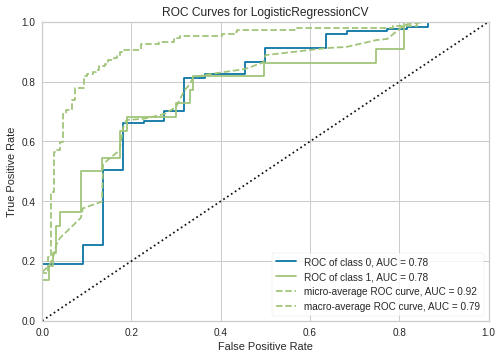

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegressionCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=[0, 1], model=None)

In [45]:
# compute and plot roc curves
# auc = measure of "seperability", roc = probability curve
# the closer the curves are to the top left-hand corner, the better the model

roc_auc(log_reg, X_train, y_train, X_test=X_test, y_test=y_test, classes=[0, 1])


## Naive Bayes

The Naive Bayes algorithm classifies classes using Bayes' theorem with the assumption of conditional independence between every pair of features, given the value of the class. It is a popular baseline in text classification because it offers several benefits:

- Naive Bayes classifiers are known to perform well on real-world data tasks.
- They require a small amount of training data to estimate the necessary parameters.
- Implementation is quick and simple.
- It is typically quite effective at text classification.

In [46]:
# fit the training dataset on the naive bayes classifier
nb = naive_bayes.ComplementNB()
nb.fit(X_train, y_train)

# model accuracy
nb_predictions = nb.predict(X_test)
model_accuracy("Naive Bayes", nb_predictions)

---Naive Bayes Test Set Results---
Weighted F1 Average: 0.8372325419305285
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       127
           1       0.47      0.36      0.41        22

    accuracy                           0.85       149
   macro avg       0.68      0.65      0.66       149
weighted avg       0.83      0.85      0.84       149



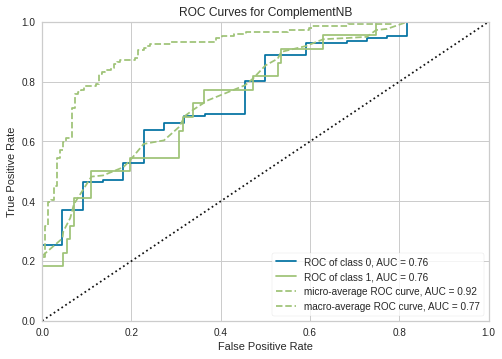

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for ComplementNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=[0, 1], model=None)

In [47]:
roc_auc(nb, X_train, y_train, X_test=X_test, y_test=y_test, classes=[0, 1])

## Support Vector Classification (SVC)

Support Vector Classifiers find the linear hyperplane (known as the decision boundary) that splits the dataset into classes with the maximum margin between the hyperplane and the nearest data-points (the support vectors). The support vectors are samples that would alter the position of the separating hyerplane if removed, meaning that those samples are the most influential in defining the placement of the decision boundary. By maximizing the functional margin, this reduces how sensitive the decision boundary is to noise, making it more generalizable.

SVCs are effective for classification problems, especially classifying text, for the following reasons:

- They are flexible and fast.
- They are effective in high-dimensional spaces.
- They don't require much training data to produce accurate results.

In [48]:
# fit the training dataset on the Support vector classifier
svc = svm.SVC(C=1, kernel="linear", class_weight="balanced")
svc.fit(X_train, y_train)

# model accuracy
svc_predictions = svc.predict(X_test)
model_accuracy("SVC", svc_predictions)

---SVC Test Set Results---
Weighted F1 Average: 0.8147422394225902
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       127
           1       1.00      0.09      0.17        22

    accuracy                           0.87       149
   macro avg       0.93      0.55      0.55       149
weighted avg       0.88      0.87      0.81       149



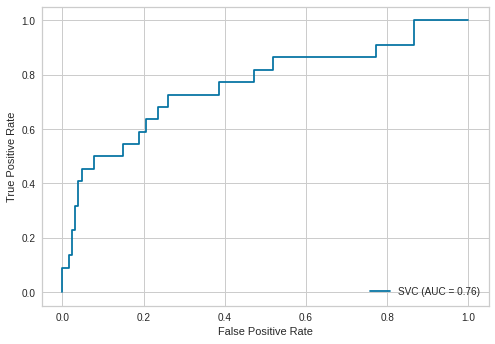

In [49]:
# error plotting yb method, using sklearn instead
## TODO - solve error and plot using more detailed yb method
plot_roc_curve(svc, X_test, y_test)

## Pickling Models (for Future Use)

In [50]:
# saving tfidf
pickle.dump(tfidf, open("tfidf.pickle", "wb"))

# saving models
pickle.dump(log_reg, open("log_reg.pickle", "wb"))
pickle.dump(nb, open("nb.pickle", "wb"))
pickle.dump(svc, open("svc.pickle", "wb"))


## Comparing Model Performance When Dealing With Imbalanced Data

While ROC Curves are useful, they are sensitive to imbalanced data, as is the case here. One alternative that helps tell us a little more about the data, and is effective when dealing with imbalanced data, is precision-recall curves.

### Precision-Recall Curve (PRC)

A Precision-Recall Curve is a measure of prediction success. The precision and recall values are calculated from multiple confusion matrices for different probability cut-offs. For example, at a cut-off of x, every case with a probability of greater than x is given a positive label (in this context, every sentence with a probability of greater than x is labeled as political). Precision and recall are calculated at multiple cut-off points, which produces a range of values for which the curve can be plotted.

- PRC effectively plots the tradeoff between the precision (% predicted accurately) and recall (% positives identified).
  - Precision is the proportion of sentences that the model identifies as political that are actually politcal (also know as the Positive Predictive Value (PPV)). Recall is the proportion of politcal sentences that were successfully predicted as political.
    - Precision = True Positives/(True Positives + False Positives)
    - Recall = True Positives/(True Positives + False Negatives)
- PRC is sensitive to data distribution, is effective for imbalanced data, and responds to positive cases more than negative, which makes it a good fit for this dataset (because there are only a small number of positive cases) and this question (because positives are more important).
- The Precision-Recall Curves below also plot average precision, which is the weighted average of precision achieved at each cut-off.
  - Average precision represents the area under the curve, and can be considered as a measure of the overall model performance.
- The goal is to maximize both precision and recall, which would mean that the model is predicting accurately for the majority of classes it selects. When this is the case, the area under the curve would be greater.

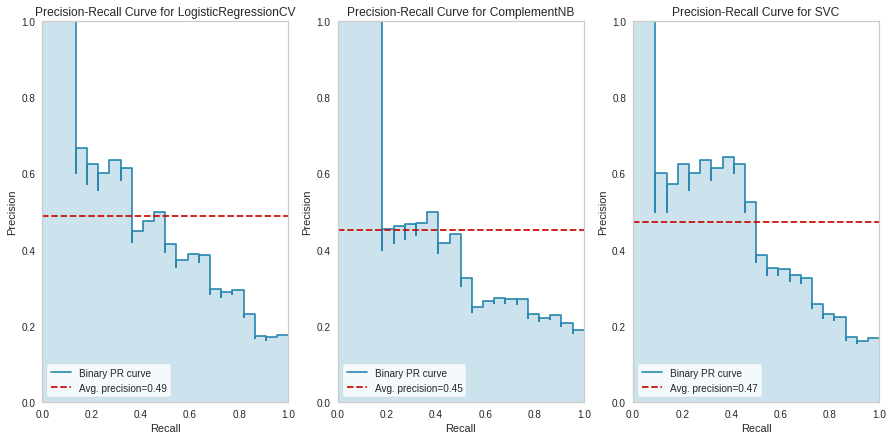

In [51]:
# precision-recall curve

# define models
models = [log_reg, nb, svc]
# set plot parameters
_, axes = plt.subplots(ncols=3, figsize=(15, 7))

# for loop calling a PRC curve on each model
for idx, ax in enumerate(axes.flatten()):
    viz = PrecisionRecallCurve(models[idx], ax=ax, show=False)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()